In [13]:
#import tensorflow as tf
#import tensorflow.keras as K
#from tensorflow.keras.applications.vgg16 import VGG16
#from tensorflow.keras.applications.resnet50 import ResNet50

#import keras
#from tensorflow.keras import layers, models
#from keras.preprocessing.image import ImageDataGenerator
#import numpy as np

import time
from datetime import timedelta

#import matplotlib.pyplot as plt

#from tensorflow.keras.models import Sequential
#from tensorflow.data import Dataset

#from tensorflow.keras.callbacks import EarlyStopping
#from tqdm import tqdm
#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.optimizers import Adagrad

from util_functions import *

In [14]:
DATA_PATH = "../../Data/"
IMG_SIZE = (224, 224)
IMAGES_PATH_SEPARATED = DATA_PATH+"HAM10000_images_separated_balanced/"
IMAGES_PATH_VALIDATION = DATA_PATH+"HAM10000_images_separated_validation/"

In [15]:
batch_size = 32
generator = ImageDataGenerator(validation_split=0.2)
train_data = generator.flow_from_directory( 
        subset="training",
        directory=IMAGES_PATH_SEPARATED,
        target_size=IMG_SIZE,
        batch_size=batch_size
)
test_data = generator.flow_from_directory( 
        subset="validation",
        directory=IMAGES_PATH_SEPARATED,
        target_size=IMG_SIZE,
        batch_size=batch_size
)

Found 781 images belonging to 7 classes.
Found 192 images belonging to 7 classes.


In [ ]:
# NOT ENOUGH MEMORY (RAM) 
# FIXED using ImageDataGenerator and flow_from_directory
'''
image_data, label_data = [], []
for images, labels in tqdm(image_ds.as_numpy_iterator()):
    for i in range(len(labels)):
        image_data.append(images[i])
        label_data.append(labels[i])
''';


105it [00:06,  8.84it/s]

In [4]:
'''
def print_training_history(history: keras.callbacks.History) -> None:
    
    epochs = len(history.history['loss'])
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Training Accuracy")
    plt.plot(epochs_range, val_acc, label="Validation Accuracy")
    plt.legend(loc="lower right")
    plt.xlabel("Epochs")
    plt.title("Training and Validation Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Training Loss")
    plt.plot(epochs_range, val_loss, label="Validation Loss")
    plt.legend(loc="upper right")
    plt.xlabel("Epochs")
    plt.title("Training and Validation Loss")
    plt.show()
''';

In [5]:
'''
def evaluate_model(model: Sequential, train_ds: Dataset, test_ds: Dataset) -> None:
    acc_value = model.evaluate(train_ds, verbose=0)[1]
    val_acc_value = model.evaluate(test_ds, verbose=0)[1]
    print("Model Accuracy      : {0:.4f}".format(acc_value))
    print("Validation Accuracy : {0:.4f}".format(val_acc_value))
''';

## VGG16

In [16]:
# Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=IMG_SIZE + (3,))
base_model.trainable = False # Not trainable weights
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
'''
# Not Fully tested but 5 epochs were slow but steady 73-73
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(224,224,3)),
    base_model,
    layers.BatchNormalization(momentum=0.9),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),    
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(7, activation="softmax")
])

optimizer = Adagrad() # Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=['accuracy'],
)

es = EarlyStopping(monitor='val_loss', mode='min', patience=5,  
                   restore_best_weights=True, min_delta=0.001)

history = model.fit(train_data, validation_data=test_data, 
                    batch_size=batch_size, epochs=50, callbacks=[es])
epochs = len(history.history['loss'])
print("Epoch Length        : {0}".format(epochs))
''';

In [ ]:
'''
# Before alteration
layers.Flatten(),
    layers.BatchNormalization(),
    
    layers.Dense(256, activation="relu"),    
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    
    layers.Dense(128, activation="relu"),    
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    
    layers.Dense(64, activation="relu"),    
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    
    layers.Dense(7, activation="softmax")
''';

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization_3 (Batc  (None, 7, 7, 512)        2048      
 hNormalization)                                                 
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 dense_13 (Dense)            (None, 512)               12845568  
                                                                 
 dense_14 (Dense)            (None, 512)               262656    
                                                      

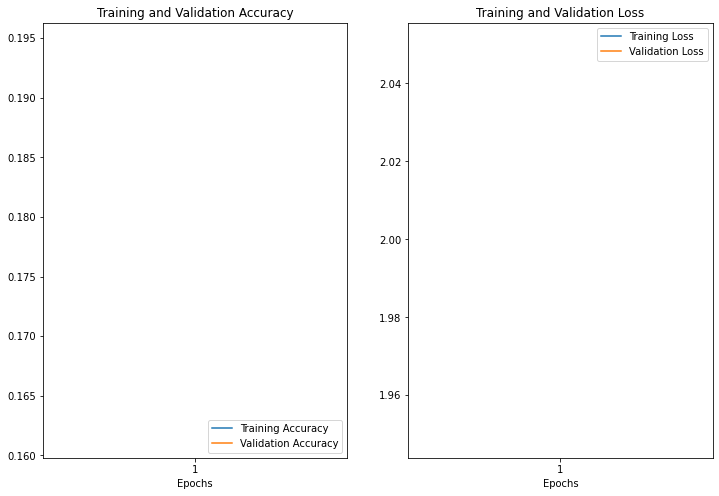

In [18]:
# Measure time
start_time = time.time()

epochs = 1
weight_init = tf.keras.initializers.HeNormal()
regularization = 0.005

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(224,224,3)),
    base_model,
    
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(512, activation="relu"),    
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.3),
    
    layers.Dense(7, activation="softmax")
])

model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001) 
# RMSprop(learning_rate=0.00002) # Adagrad() # Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=['accuracy'],
)

#es = EarlyStopping(monitor='val_loss', mode='min', patience=3,  
#                   restore_best_weights=True, min_delta=0.01)

history = model.fit(train_data, validation_data=test_data, 
                    batch_size=batch_size, epochs=epochs) #, callbacks=[es])
epochs = len(history.history['loss'])

print("Epoch Length        : {0}".format(epochs))
print("Time Elapsed : ", timedelta(seconds=(time.time() - start_time)))

model.save("output\keras_models\skin_classifier_VGG16_{0}.keras".format(epochs))

print_training_history(history)

# VGG16 BN + Dense512+Dense512 + DO.3 Balanced+Rotated ##

In [19]:
evaluate_model(model, train_data, test_data)

Model Accuracy      : 0.1524
Validation Accuracy : 0.1615


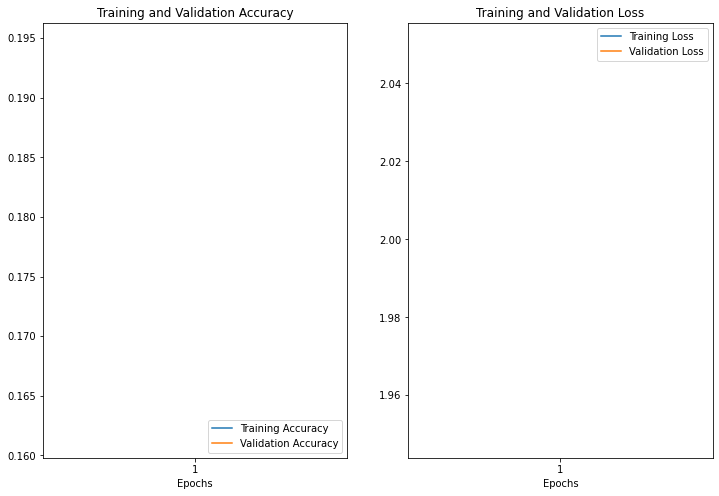

In [20]:
print_training_history(history)

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file="output/vgg16.png")

## ResNet50 (TEST) DO THIS AGAIN

In [21]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=IMG_SIZE + (3,))
base_model.trainable = False # Not trainable weights
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

25/25 [==============================] - 40s 2s/step - loss: 2.1299 - accuracy: 0.1306 - val_loss: 2.1228 - val_accuracy: 0.1302
Epoch Length        : 1
Time Elapsed :  0:00:40.211841


D:\Programs\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


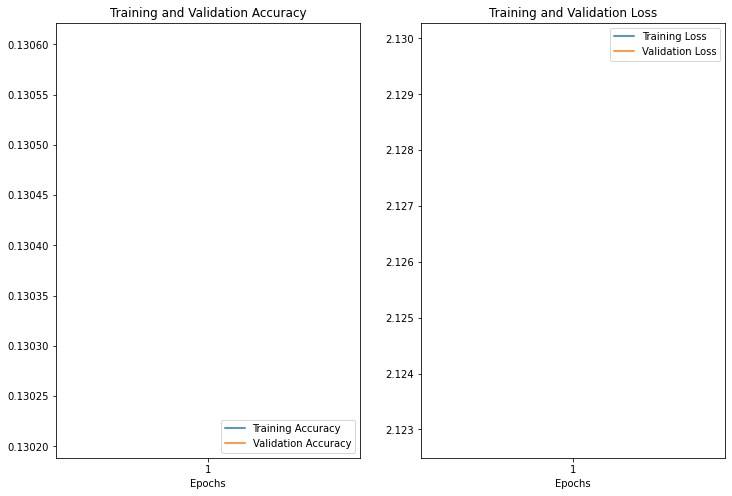

In [23]:
# Measure time
start_time = time.time()

epochs = 1

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(224,224,3)),
    base_model,
   
    # same as in original model
    layers.GlobalAveragePooling2D(),
    
    #layers.Flatten(),
    #layers.Dense(512),
    
    #layers.Dropout(0.4),
    #layers.BatchNormalization(),
    
    layers.Dense(7, activation="softmax")
])

# First run on the model the was no overfitting
# but overal model was weak, so decided to try differnt optimizer
# Small rate used for transfer learning

# Optimization algorithms in machine learning (especially in neural networks) 
# aim at minimizing an objective function (generally called loss or cost function), 
# which is intuitively the difference between the predicted data and the expected values

# Although ADAGRAD works well for sparse settings, 
# its performance has been observed to deteriorate in settings 
# where the loss functions are nonconvex and gradients are dense 
# due to the rapid decay of the learning rate in these settings 
# since it uses all the past gradients in the update

# Simply put, RMSprop uses an adaptive learning rate 
# instead of treating the learning rate as a hyperparameter. 
# This means that the learning rate changes over time
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001) 
# RMSprop(learning_rate=0.00002) # Adagrad() # Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=['accuracy'],
)

model.summary()

#es = EarlyStopping(monitor='val_loss', mode='min', patience=3,  
#                   restore_best_weights=True, min_delta=0.01)

history = model.fit(train_data, validation_data=test_data, 
                    batch_size=batch_size, epochs=epochs) #, callbacks=[es])
epochs = len(history.history['loss'])
print("Epoch Length        : {0}".format(epochs))
print("Time Elapsed : ", timedelta(seconds=(time.time() - start_time)))

model.save("output\keras_models\skin_classifier_ResNet50_{0}.keras".format(epochs))
print_training_history(history)
# ResNet50 + GAP, Balanced+Rotated

Epoch 1/10
240/240 [==============================] - 664s 3s/step - loss: 2.1541 - accuracy: 0.1567 - val_loss: 2.0633 - val_accuracy: 0.1567
Epoch 2/10
240/240 [==============================] - 662s 3s/step - loss: 2.0149 - accuracy: 0.1567 - val_loss: 1.9791 - val_accuracy: 0.1567
Epoch 3/10
240/240 [==============================] - 663s 3s/step - loss: 1.9633 - accuracy: 0.1569 - val_loss: 1.9513 - val_accuracy: 0.1577
Epoch 4/10
240/240 [==============================] - 662s 3s/step - loss: 1.9473 - accuracy: 0.1567 - val_loss: 1.9435 - val_accuracy: 0.1548
Epoch 5/10
240/240 [==============================] - 662s 3s/step - loss: 1.9433 - accuracy: 0.1559 - val_loss: 1.9418 - val_accuracy: 0.1504
Epoch 6/10
240/240 [==============================] - 662s 3s/step - loss: 1.9423 - accuracy: 0.1554 - val_loss: 1.9412 - val_accuracy: 0.1462
Epoch 7/10
240/240 [==============================] - 662s 3s/step - loss: 1.9419 - accuracy: 0.1371 - val_loss: 1.9408 - val_accuracy: 0.1311

D:\Programs\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


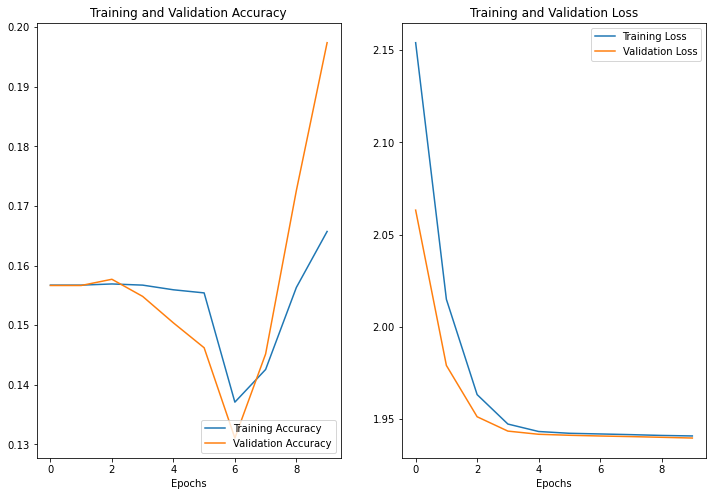

In [9]:
# ResNet50 + GAP, Balanced+Rotated

In [24]:
evaluate_model(model, train_data, test_data)

Model Accuracy      : 0.1306
Validation Accuracy : 0.1302


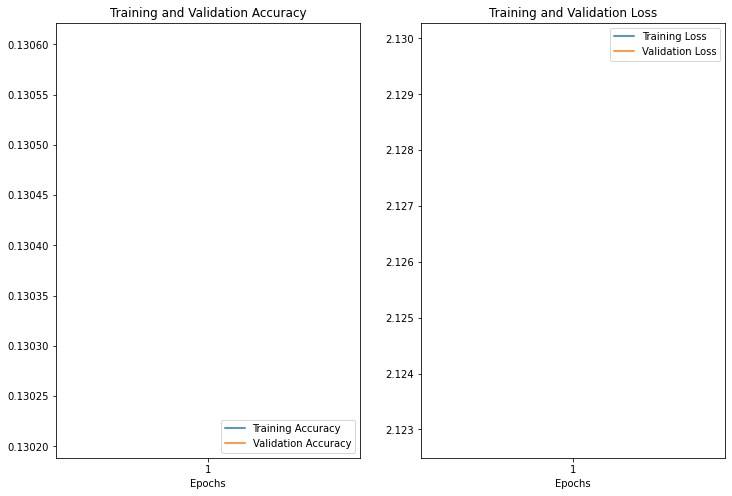

In [25]:
print_training_history(history)